#Introduction:

This project implements a “from-scratch” K-Nearest Neighbors (KNN) approach to recommend the bird with missing sightings. We chose KNN because it is a simple, instance-based supervised learning algorithm that directly uses training data for predictions. It requires setting a value for K and selecting an appropriate distance metric. Large Language Models (LLMs) provided valuable assistance in understanding concepts, reasoning through each step, and generating code for the project.

#Approach:

Our approach involves splitting the data into training and test sets and mimicking real-world missing bird sightings to create a ground truth.

**Step 1:** We applied experimentations based on raw data and normalized data. Min-Max normalization and log normalization were applied to the data, ensuring that all sightings are scaled equally and reducing the impact of skewed data.

**Step 2:** The training data was split into two sets: train_split and test_split. The test_split simulates the original test set.

**Step 3:** We applied k-fold cross-validation (k=5) to further assess the model's performance. In each fold, a portion of the training data was treated as a validation set to ensure that the model generalizes well and doesn't overfit to specific data splits.


**Step 4:** We calculated distances between the test_split and train_split using several distance metrics: Euclidean Distance, Manhattan Distance, Cosine Distance, and Jaccard Distance. Each metric captures different aspects of similarity. For making the process faster, we implemented batch processing.

**Step 5:** We identified the K nearest neighbors based on each distance metric and ranked these neighbors to find the most similar sightings.

**Step 6:** To simulate missing sightings, we randomly selected five non-zero bird sightings in the test set and set them to zero, creating a ground truth for evaluation. We stored the original values in a separate DataFrame for comparison (expected recommendations).

**Step 7:** Using the KNN, we predicted the five missing birds by analyzing the sightings of their nearest neighbors. We evaluated these predictions by comparing them to the ground truth using metrics such as Mean Absolute Error (MAE).

**Step 8:** We evaluated Jaccard, Euclidean, and Cosine distance metrics for K values ranging from 1 to 50 in our recommender system to see which metrics and K value gives us the low MAE. We used k-fold cross validation for splitting training and test set.


**Step 9:** For improving our score, we tried min-max normalization as a preprocessing step.

**Step 10:** Following our previous attempts to improve score, we implemented log1p and log(1+βx) normalization.


#Results:

Through analysis, we identified the most effective distance measure (Cosine) and an appropriate range for K (10-20) for data without any preprocessing. The optimal configuration yielded a Mean Absolute Error between 0.051 and 0.053 in Kaggle and around 0.041-0.042 during training.

Despite implementing min-max normalization as a preprocessing technique, our model's Mean Absolute Error (MAE) score remained within the previously mentioned range. We believe this lack of improvement may be attributed to two key limitations of min-max normalization: its sensitivity to outliers and potential loss of information during the scaling process.

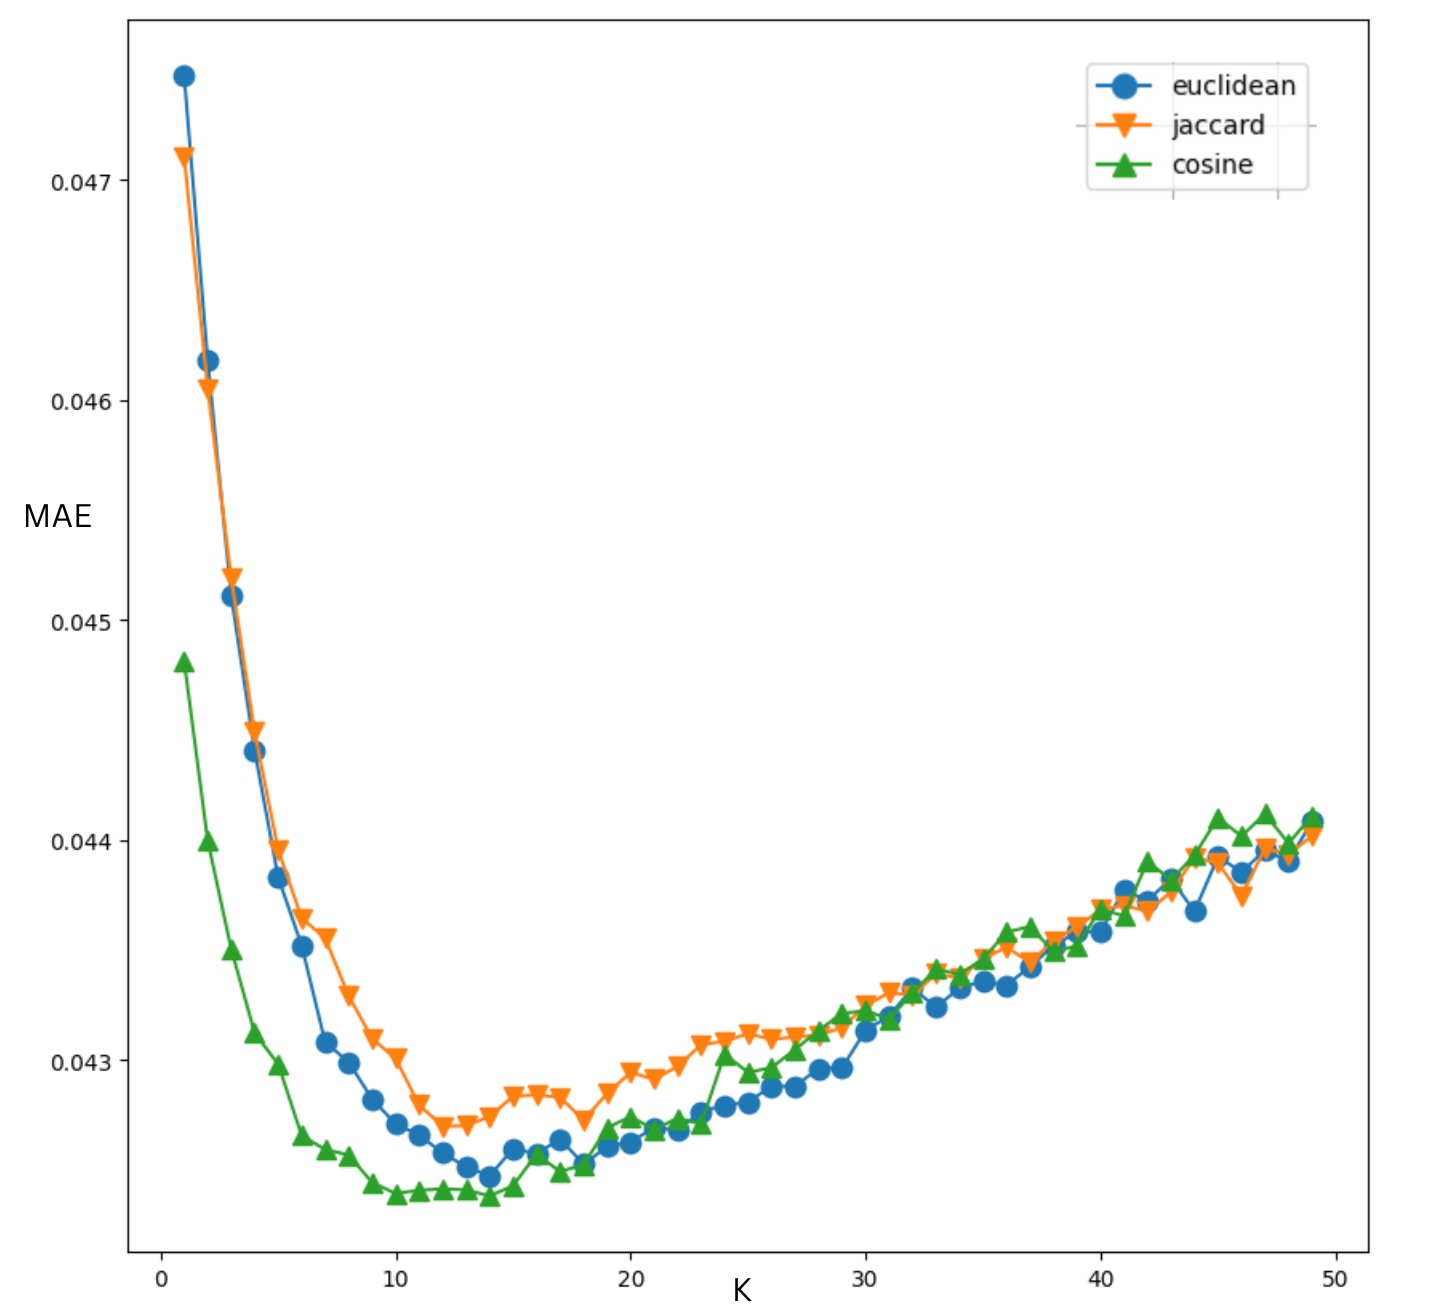

After applying log1p normalization, we observed better scores in Kaggle (ranging from 0.045 to 0.048) and in training (ranging from 0.026-0.027) when using Jaccard and Cosine distance metrics. We then refined our approach by applying a more generalized logarithmic normalization: log(1+βx). We experimented with β values between 1000 and 3000. This method produced kaggle scores in the range of 0.044 to 0.045 for the same distance metrics and K values we had previously tested. For the training set we got MAE from 0.020 to 0.022. These results indicate a notable improvement in our model's performance compared to our earlier normalization attempts.

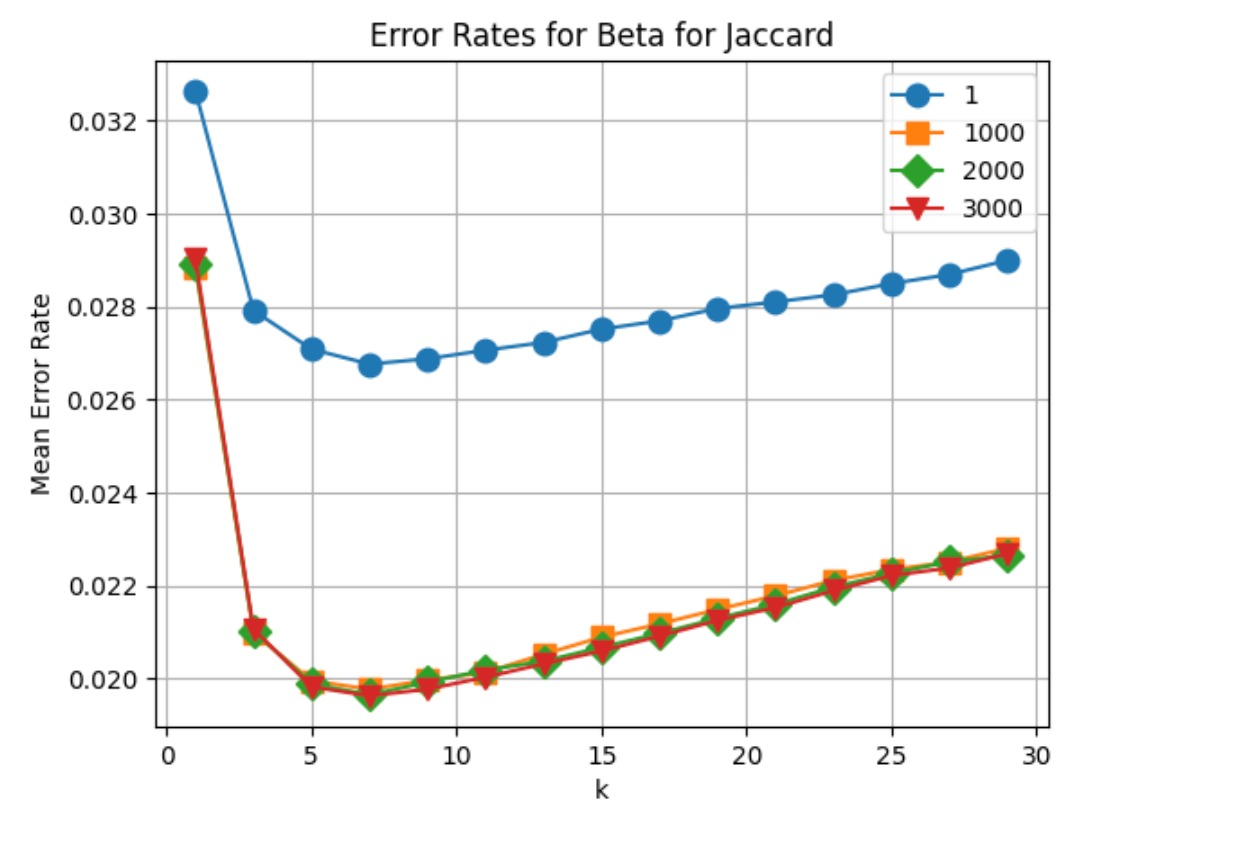





#Conclusion:

In this project, we implemented a KNN-based recommender system from scratch, using multiple distance metrics to identify missing bird sightings. By tuning K and normalizing the data, we improved the model’s accuracy and reduced potential bias in sighting counts.

Among the three distance metrics, Jaccard and Cosine distance metrics are well suited as they handle the robustness of sparse data well, and in this dataset, many sightings were missing, hence we can see zero on most datapoints mimicing the sparse data. The log normalization with different β provided us with the lowest kaggle score for both Jaccard and Cosine distance. When we were selecting neighbours, low MAE was seen for K = 10 to 20 neighbors.

### Code Explanation:

First we import the libraries and the dataset.

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

df = pd.read_csv('training_set.csv')

By creating a histogram of our sightings data, we can visualize its distribution. Upon examination of this histogram, it becomes evident that the data exhibits a right skewed pattern.

In [ ]:
def create_histogram(df):
    flattened_data = df.values.flatten()

    # Create a histogram
    plt.figure(figsize=(12, 6))
    plt.hist(flattened_data, bins="auto", edgecolor="black")
    plt.title("Histogram of Integer Values in DataFrame")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.grid(True, alpha=0.3)
    plt.show()

    value_counts = pd.Series(flattened_data).value_counts().sort_index()
    print(value_counts)

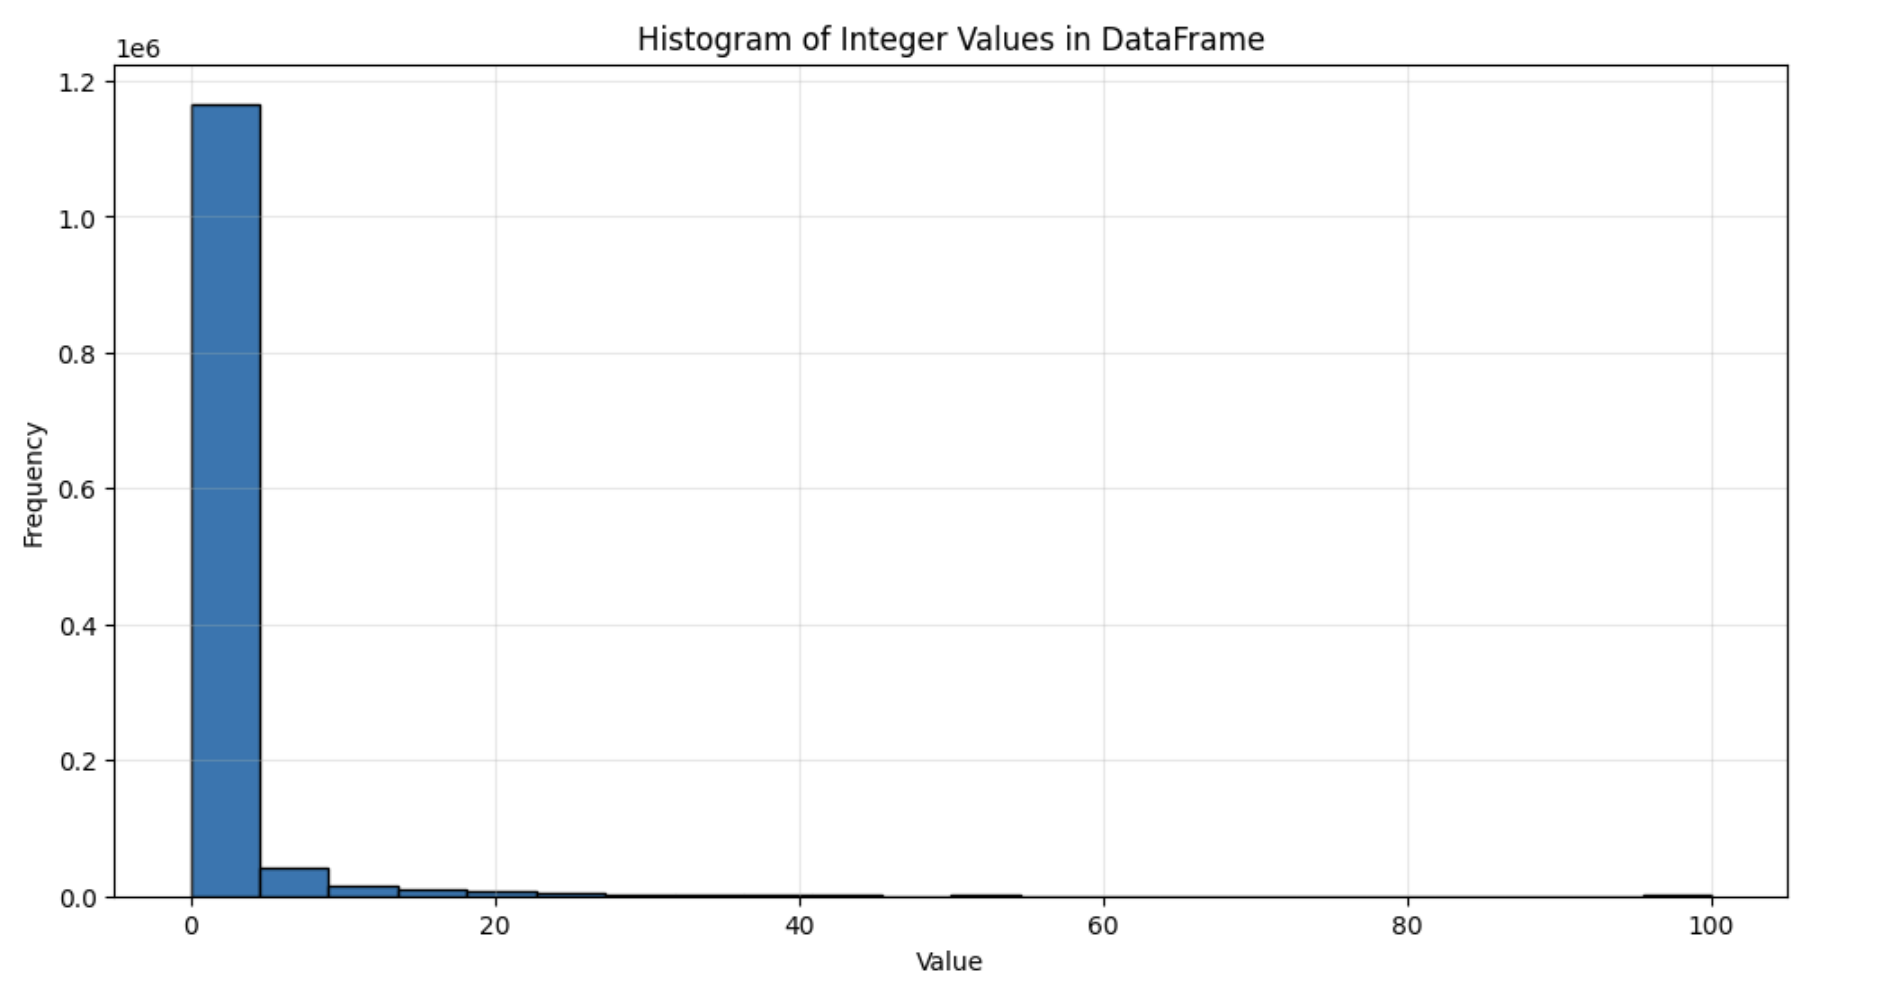

Our data preprocessing stage incorporates two distinct normalization methods to standardize the dataset. We have implemented specific functions that execute the required steps for both min-max normalization and log normalization. These functions serve as essential components in our data preparation pipeline, ensuring that the dataset is appropriately scaled and transformed before being fed into our model.

In [ ]:
def min_max_normalization(df):
    min_values = df.min()
    max_values = df.max()

    range_values = max_values - min_values
    range_values[range_values == 0] = 1

    normalized_df = (df - min_values) / range_values

    return normalized_df


def log1p_normalization(df):
    return np.log1p(df)


def log_normalization(df, beta):
    return np.log(1 + beta * df)

This function is responsible for generating and returning the cross-validation training and test sets for a specified fold. The function supports a 5-fold cross-validation process, allowing the user to select any fold number from 1 to 5. Each fold represents a unique split of the data into training and test sets, ensuring a comprehensive evaluation of the model's performance across different data partitions.

In [ ]:
def k_fold_dataset(fold, training_data):
    column_count = training_data.shape[1]
    fold_size = int(0.20 * (column_count - 1))

    if fold == 1:
        test_first_column = 1
        test_last_column = 1 + fold_size
    elif fold == 2:
        test_first_column = 1 + fold_size
        test_last_column = 1 + 2 * fold_size
    elif fold == 3:
        test_first_column = 1 + 2 * fold_size
        test_last_column = 1 + 3 * fold_size
    elif fold == 4:
        test_first_column = 1 + 3 * fold_size
        test_last_column = 1 + 4 * fold_size
    elif fold == 5:
        test_first_column = 1 + 4 * fold_size
        test_last_column = column_count
    else:
        raise ValueError("Fold must be between 1 and 5")

    test_set = training_data.iloc[:, test_first_column:test_last_column].astype(
        "float32"
    )

    train_set_left = training_data.iloc[:, 1:test_first_column]
    train_set_right = training_data.iloc[:, test_last_column:]
    train_set = pd.concat([train_set_left, train_set_right], axis=1).astype("float32")

    return train_set, test_set


To enhance efficiency, we implement batch processing when computing distances between the training and testing sets. Our approach utilizes three distance metrics: Jaccard, Euclidean, and Cosine. To optimize both speed and memory usage, we leverage matrix operations for these distance calculations. This method allows us to process large datasets more effectively, reducing computation time while maintaining memory efficiency.

In [ ]:
def calculate_distances_similarities_batched(
    train0, test0, metrics=["euclidean", "jaccard", "cosine"], batch_size=1000
):
    train_array = train0.values
    test_array = test0.values

    results = {
        metric: pd.DataFrame(
            index=train0.columns, columns=test0.columns, dtype=np.float32
        )
        for metric in metrics
    }

    for i in range(0, train_array.shape[1], batch_size):
        batch_end = min(i + batch_size, train_array.shape[1])
        train_batch = train_array[:, i:batch_end]

        for j in range(0, test_array.shape[1], batch_size):
            test_batch_end = min(j + batch_size, test_array.shape[1])
            test_batch = test_array[:, j:test_batch_end]

            for metric in metrics:
                if metric == "euclidean":
                    diff = train_batch[:, :, np.newaxis] - test_batch[:, np.newaxis, :]
                    distances = np.sqrt(np.sum(diff**2, axis=0))
                elif metric == "manhattan":
                    diff = train_batch[:, :, np.newaxis] - test_batch[:, np.newaxis, :]
                    distances = np.sum(np.abs(diff), axis=0)
                elif metric == "jaccard":
                    dot_product = np.dot(train_batch.T, test_batch)
                    square_sum_train = np.sum(train_batch**2, axis=0)
                    square_sum_test = np.sum(test_batch**2, axis=0)
                    distances = 1 - (
                        dot_product
                        / (
                            square_sum_train[:, np.newaxis]
                            + square_sum_test[np.newaxis, :]
                            - dot_product
                        )
                    )
                elif metric == "cosine":
                    norm_train = np.linalg.norm(train_batch, axis=0)
                    norm_test = np.linalg.norm(test_batch, axis=0)
                    dot_product = np.dot(train_batch.T, test_batch)
                    distances = 1 - (
                        dot_product
                        / (norm_train[:, np.newaxis] * norm_test[np.newaxis, :])
                    )

                results[metric].iloc[i:batch_end, j:test_batch_end] = distances

    return results


After generating the distance matrix, we employ a selection process to identify the K nearest neighbors for each sightings. Specifically, we choose the K entries with the smallest distance values from the matrix. These selected neighbors form the basis for our recommendation algorithm, as they represent the most similar sightings according to our chosen distance metrics.

In [ ]:
def get_k_nearest_neighbors(distance_matrix, k=5):
    k_nearest_neighbor_list = {}
    for i in distance_matrix.columns:
        k_nearest_neighbor_list[i] = distance_matrix[i].nsmallest(k).index.tolist()
    return k_nearest_neighbor_list


We evaluate our models' performance by deliberately setting five sightings to 0 in the test portion of our dataset. We keep track of which data points we modified. After running our model, these modified data points serve as a benchmark for our recommender system. The effectiveness of our model is measured by how well the recommender system's suggestions align with the intentionally zeroed-out data points. A higher match rate indicates a more accurate model.

In [ ]:
def calculate_ground_truth(test_set_):
    update_test_copy = test_set_.copy(deep=True).astype("float32")
    ground_truth_list = []

    for i in update_test_copy.columns:
        indices = update_test_copy[i].to_numpy().nonzero()[0]
        random_indices = random.sample(indices.tolist(), min(len(indices), 5))
        possible_recommendation_df = pd.DataFrame(
            0, index=np.arange(update_test_copy.shape[0]), columns=[i]
        ).astype("float32")
        for j in random_indices:
            update_test_copy[i][j] = 0
            possible_recommendation_df[i][j] = 1
        ground_truth_list.append(possible_recommendation_df)

    ground_truth_df = pd.concat(ground_truth_list, axis=1)
    return ground_truth_df, update_test_copy


A k-nearest neighbor approach was employed to recommend bird sightings. For each bird, the maximum sighting count among its k nearest neighbors was determined. The top five birds with the highest cumulative sighting counts were then selected for recommendation.

In [ ]:
def get_recommendations(k_nearest_neighbor_list, updated_test_set, train_set_):
    recommendations_list = []

    for i in k_nearest_neighbor_list:
        indices = updated_test_set[i].to_numpy().nonzero()[0]
        neighbor_df = []
        for j in k_nearest_neighbor_list[i]:
            neighbor_df.append(train_set_[j])
        neighbors_df = pd.concat(neighbor_df, axis=1).astype("float32")

        dropped_df = neighbors_df.drop(indices, axis=0)
        dropped_df["occurence"] = dropped_df.sum(axis=1).astype("float32")
        max_summations = dropped_df["occurence"].nlargest(5)
        recommendation_indices = max_summations.index.values.tolist()
        recommendation_df = pd.DataFrame(
            0, index=np.arange(train_set_.shape[0]), columns=[i]
        )
        for k in recommendation_indices:
            recommendation_df[i][k] = 1
        recommendations_list.append(recommendation_df)

    recommendations_df = pd.concat(recommendations_list, axis=1).astype("float32")
    return recommendations_df

In this step, the MAE is calculated, which quantifies the average difference between predicted and actual bird sightings.



In [ ]:
def calculate_mae(recommendations_df, ground_truth_df, test_):
    diff_df = recommendations_df - ground_truth_df
    diff_df = diff_df.abs()
    error_sum = diff_df.to_numpy().sum()
    mae = error_sum / (test_.shape[0] * test_.shape[1])
    return mae


This step iteratively calculates the Mean Absolute Error (MAE) for different values of k (the number of nearest neighbors) and for various distance metrics (Euclidean, Jaccard, Cosine). For each metric, it identifies the k-nearest neighbors, generates recommendations, compares them against the ground truth, and stores the MAE. The process determines the optimal combination of metric and k by tracking the lowest MAE during each iteration.

**`knn_recommender` function parameter list:**


---


`train_dataframe`: Required. The training split dataframe.

`metrics`: By default it takes an array of 'euclidean', 'jaccard' and 'cosine' distances.

`batch_size`: For calculating the distance metrics, we can increase and decrease batch size.

`normalization`: `min_max`, `log1p`, `log`. This param decides which normalization to use.

`beta`: β variable for log normalization. Default value 1, which provides log1p normalization.

`k_fold`: Decides how many folds it should run cross validation for.

`k_start`: Starting k parameter for K-nearest neighbour.

`k_end`: Ending k parameter for K-neareset neighbour.

`k_increment`: How many steps should be incremented for k in K-nearest neighbor.

In [ ]:
def knn_recommender(
    train_dataframe,
    metrics=["euclidean", "jaccard", "cosine"],
    batch_size=1000,
    normalization="None",
    beta=1,
    k_fold=5,
    k_start=1,
    k_end=20,
    k_increment=1,
):
    min_mae = 1
    min_metric = ""
    min_k = 0
    error_rate = {"euclidean": [], "jaccard": [], "cosine": []}

    for fold in range(1, k_fold + 1):
        test0, train0 = k_fold_dataset(fold, train_dataframe)

        if normalization == "min_max":
            train0 = min_max_normalization(train0)
            test0 = min_max_normalization(test0)

        if normalization == "log1p":
            train0 = log1p_normalization(train0)
            test0 = log1p_normalization(test0)

        if normalization == "log_beta":
            train0 = log_normalization(train0, beta)
            test0 = log_normalization(test0, beta)

        results = calculate_distances_similarities_batched(train0, test0, metrics, 1000)

        for metric, distance_matrix in results.items():
            fold_error = []
            for k in range(k_start, k_end + 1, k_increment):
                k_nearest_neighbor_list = get_k_nearest_neighbors(distance_matrix, k)
                ground_truth_df, updated_test_set = calculate_ground_truth(test0)
                recommendations_df = get_recommendations(
                    k_nearest_neighbor_list, updated_test_set, train0
                )
                mae = calculate_mae(recommendations_df, ground_truth_df, test0)
                min_mae = min(min_mae, mae)
                if mae == min_mae:
                    min_metric = metric
                    min_k = k
                print(f"For {metric} K = {k} : {mae}")
                fold_error.append(mae)
            error_rate[metric].append(fold_error)

    print(f"Min MAE: {min_mae}, Metric: {min_metric}, K: {min_k}")
    generate_error_vs_metrics_graph(error_rate, k_start, k_end, k_increment, k_fold, metrics)


def generate_error_vs_metrics_graph(error_rate, k_start, k_end, k_increment, k_fold, metrics=["euclidean", "jaccard", "cosine"]):
    # Getting the mean error rate:
    mean_error_rate = {
        "euclidean": [0 for element in range(k_start, k_end + 1, k_increment)],
        "jaccard": [0 for element in range(k_start, k_end + 1, k_increment)],
        "cosine": [0 for element in range(k_start, k_end + 1, k_increment)],
    }

    error_rate_length = len(mean_error_rate["euclidean"])

    for m in error_rate:
        x = error_rate[m]
        if len(x) == 0:
            continue
        for i in range(0, k_fold):  # fold
            for j in range(0, error_rate_length):  # how many k
                mean_error_rate[m][j] += x[i][j]

        for j in range(0, error_rate_length):
            mean_error_rate[m][j] = mean_error_rate[m][j] / k_fold

    markers = {"euclidean": "o", "jaccard": "v", "cosine": "^"}
    x_range = range(k_start, k_end + 1, k_increment)

    for metric in metrics:
        if len(error_rate[metric]) != 0:
            plt.plot(
                x_range,
                mean_error_rate[metric],
                marker=markers[metric],
                markersize=9,
                label=metric
            )

    plt.xlabel("k")
    plt.ylabel("Mean Error Rate")
    plt.title("Error Rates for Different Distance Metrics")
    plt.legend()
    plt.grid(True)
    plt.show()


knn_recommender_params = {
    "train_dataframe": df,
    "metrics": ["euclidean", "jaccard", "cosine"],
    "batch_size": 1000,
    "normalization": "None",
    "beta": 1,
    "k_fold": 5,
    "k_start": 1,
    "k_end": 50,
    "k_increment": 1,
}


knn_recommender(**knn_recommender_params)

 This is a line graph where the y-axis represents the Mean Absolute Error (MAE), which measures the average magnitude of errors in predictions and the x-axis represents the value of (k), which is the number of nearest neighbors considered in the KNN algorithm.

### **Trends in the graph:**

**Initial Decrease:** For all three metrics, there is a sharp decrease in MAE as (k) increases from a low value. This suggests that considering more neighbors initially improves the model’s accuracy.


**Flattening Out:** After a certain point, the lines begin to flatten, indicating that further increasing (k) does not significantly improve accuracy and may even lead to a slight increase in MAE.






 By comparing the lines, one can determine that cosine distance metric performs best for different values of k in range of 10-20 which indicates that they are more effective for this dataset.

 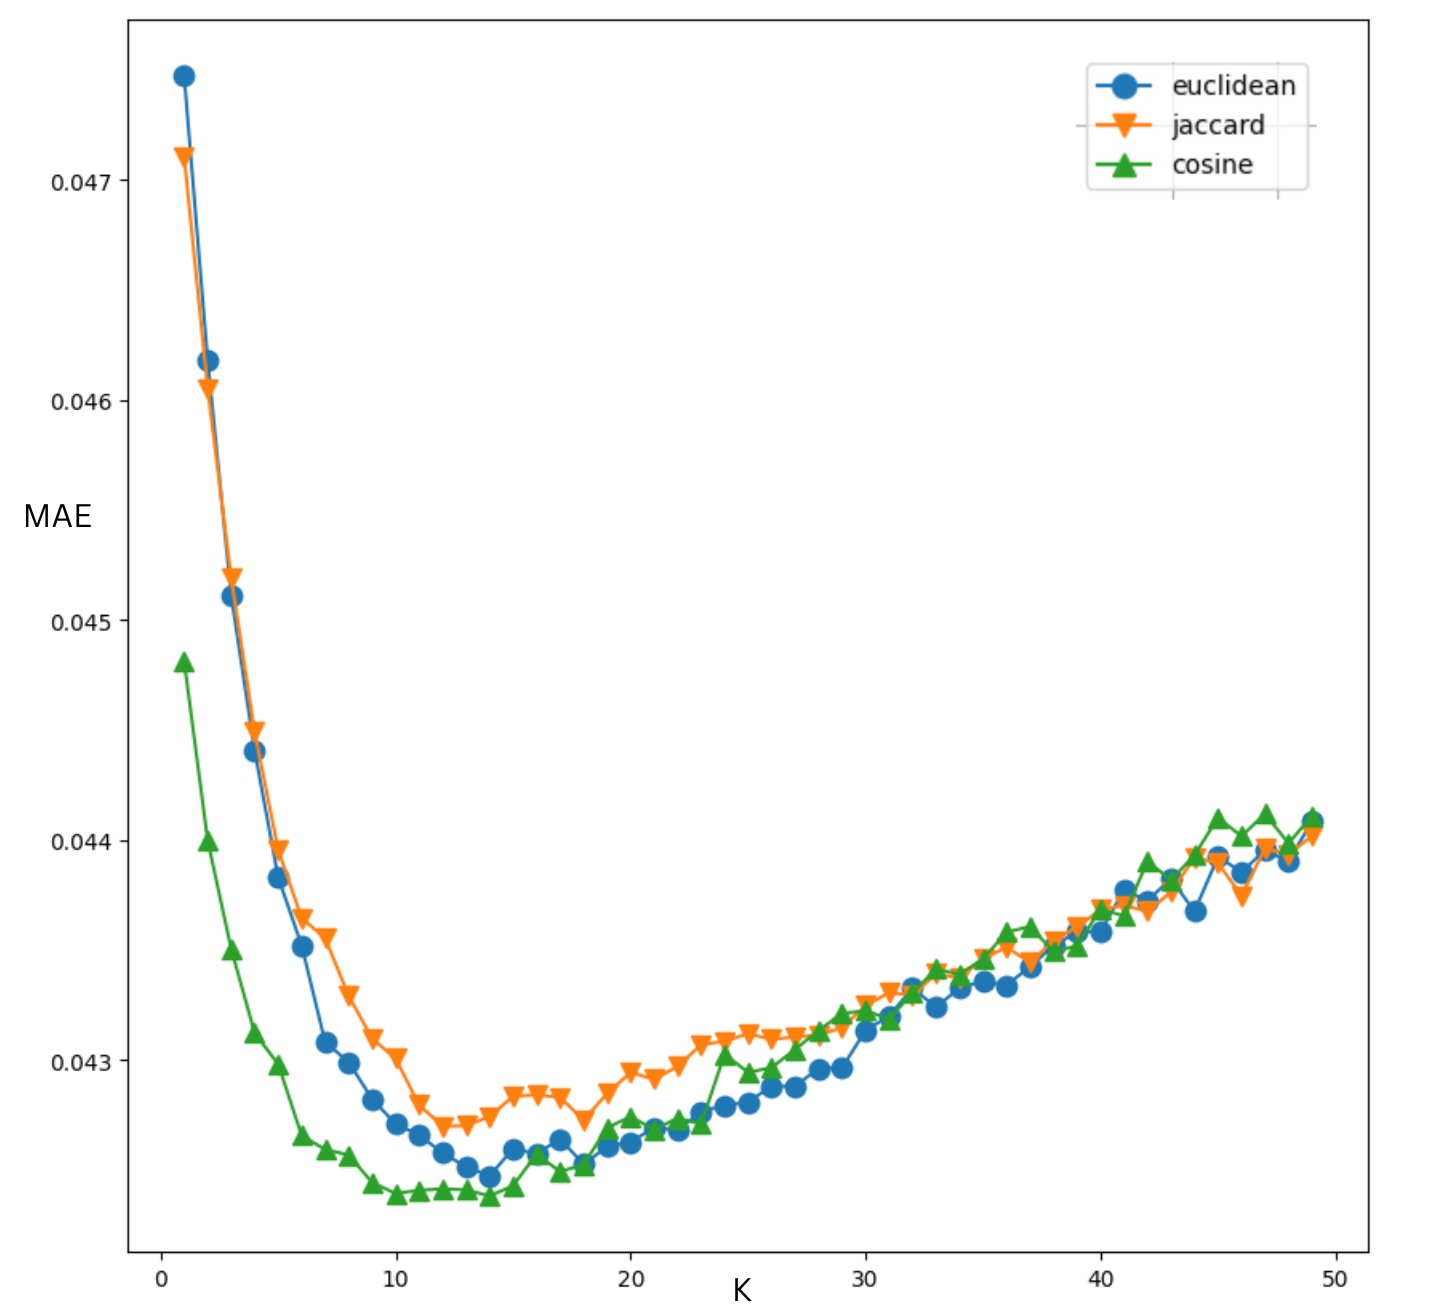

Following our initial steps, we applied various preprocessing techniques to our training data in an effort to enhance our model's performance. One approach we tested was min-max normalization, but this didn't yield significant improvements in the Mean Absolute Error (MAE).
We then explored logarithmic transformations.

Specifically, we implemented both log1p normalization and standard log normalization with different β values. To assess their effectiveness, we plotted MAE graphs for each variation, focusing on the Jaccard distance metric.

The log1p provided us with lower MAE for holdout cross validation for all of the distance metrics.

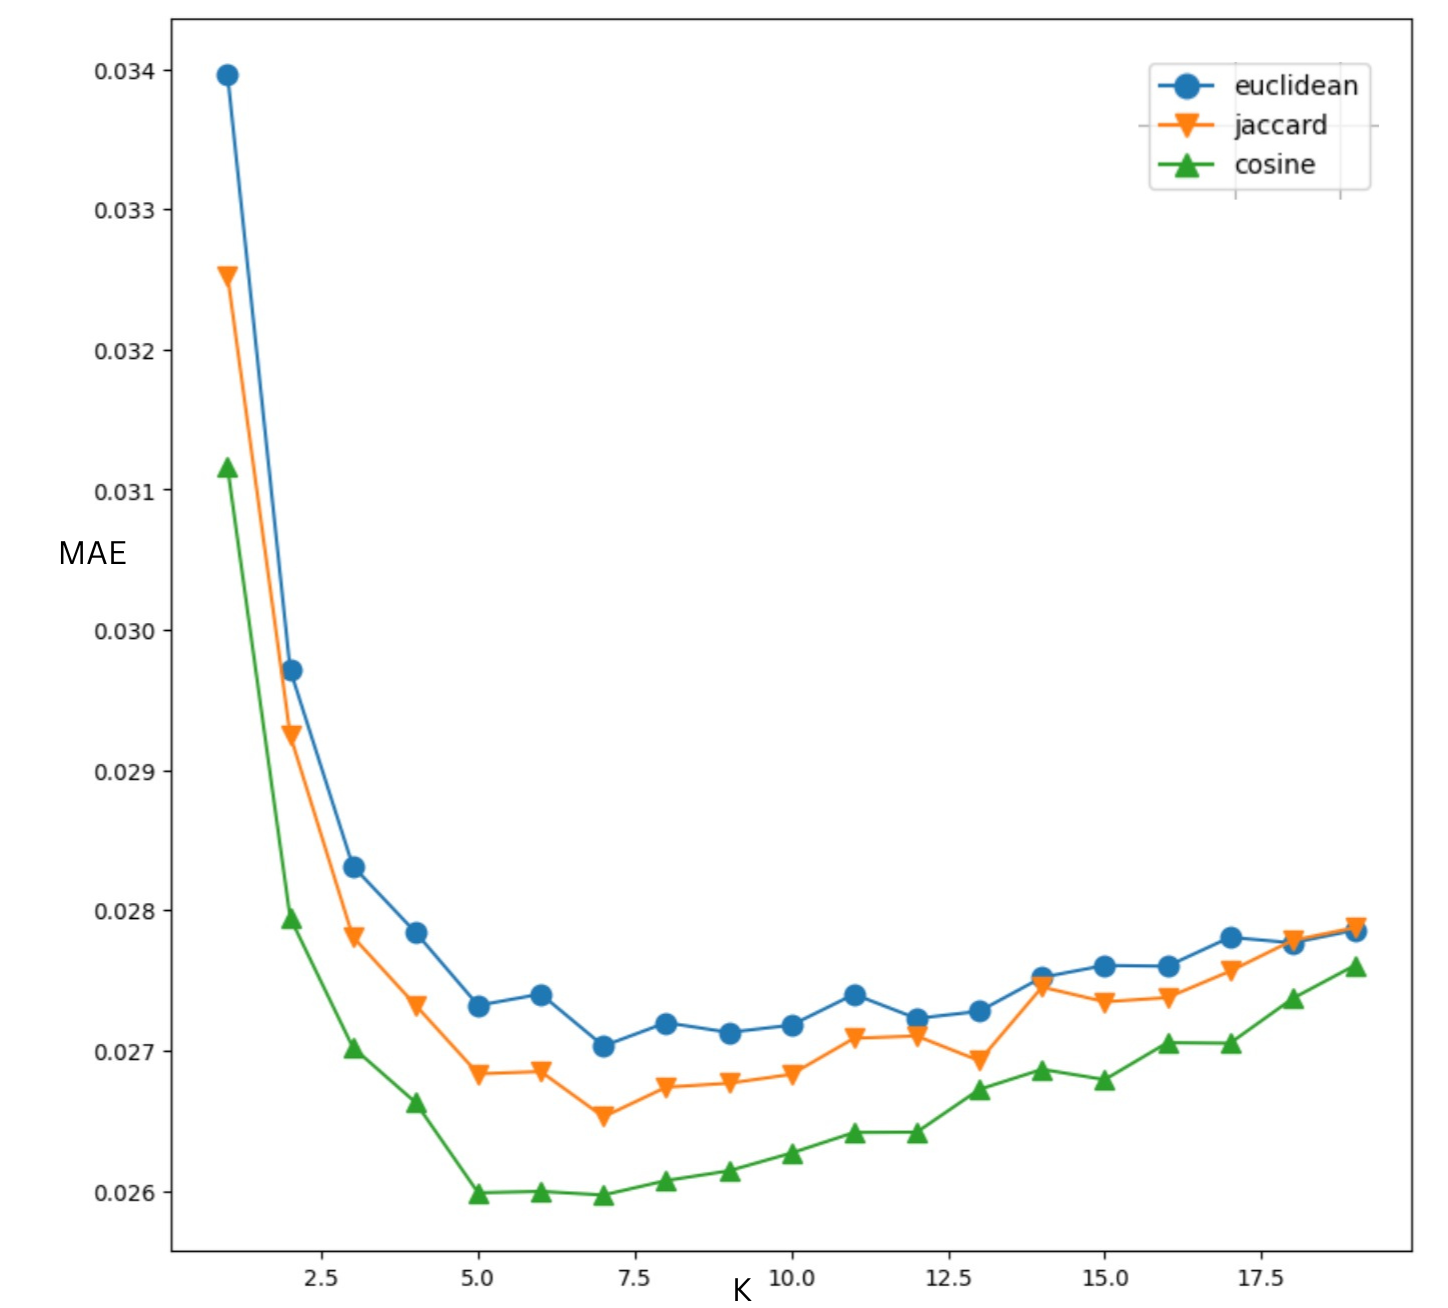

We following code runs the cross validation with β normalization with different β parameters for one distance metrics.

In [ ]:
from itertools import cycle


def generate_markers(dictionary):
    marker_list = [
        "o",
        "s",
        "D",
        "v",
        "^",
        "<",
        ">",
        "p",
        "*",
        "h",
        "H",
        "+",
        "x",
        "d",
        "|",
        "_",
    ]
    marker_cycle = cycle(marker_list)
    markers = {key: next(marker_cycle) for key in dictionary.keys()}

    return markers


def generate_error_vs_beta_graph(
    error_rate, k_start, k_end, k_increment, k_fold, betas
):
    mean_error_rate = {
        beta: [0 for element in range(k_start, k_end + 1, k_increment)]
        for beta in betas
    }

    error_rate_length = len([0 for element in range(k_start, k_end + 1, k_increment)])

    for m in error_rate:
        x = error_rate[m]
        if len(x) == 0:
            continue
        for i in range(0, k_fold):
            for j in range(0, error_rate_length):
                mean_error_rate[m][j] += x[i][j]

        for j in range(0, error_rate_length):
            mean_error_rate[m][j] = mean_error_rate[m][j] / k_fold

    markers = generate_markers(mean_error_rate)
    x_range = range(k_start, k_end + 1, k_increment)

    for beta in betas:
        if len(error_rate[beta]) != 0:
            plt.plot(
                x_range,
                mean_error_rate[beta],
                marker=markers[beta],
                markersize=9,
                label=beta,
            )
    plt.xlabel("k")
    plt.ylabel("Mean Error Rate")
    plt.title("Error Rates for Beta for Jaccard")
    plt.legend()
    plt.grid(True)
    plt.show()


def beta_log_normalization_tuning(
    train_dataframe,
    metric="jaccard",
    batch_size=1000,
    betas=[i for i in range(1000, 11000, 1000)],
    k_start=1,
    k_end=20,
    k_increment=1,
    k_fold=1,
):
    error_rate = {beta: [] for beta in betas}
    min_mae = 1
    min_metric = ""
    min_k = 0
    for fold in range(1, k_fold + 1):
        for beta in betas:
            test0, train0 = k_fold_dataset(fold, train_dataframe)
            train0 = log_normalization(train0, beta)
            test0 = log_normalization(test0, beta)

            results = calculate_distances_similarities_batched(
                train0, test0, [metric], 1000
            )

            distance_matrix = results[metric]
            fold_error = []
            for k in range(k_start, k_end + 1, k_increment):
                k_nearest_neighbor_list = get_k_nearest_neighbors(distance_matrix, k)
                ground_truth_df, updated_test_set = calculate_ground_truth(test0)
                recommendations_df = get_recommendations(
                    k_nearest_neighbor_list, updated_test_set, train0
                )
                mae = calculate_mae(recommendations_df, ground_truth_df, test0)
                min_mae = min(min_mae, mae)
                if mae == min_mae:
                    min_metric = metric
                    min_k = k
                print(f"For beta {beta} K = {k} : {mae}")
                fold_error.append(mae)
            error_rate[beta].append(fold_error)

    generate_error_vs_beta_graph(error_rate, k_start, k_end, k_increment, k_fold, betas)


beta_log_normalization_tuning_params = {
    "train_dataframe": df,
    "metric": "jaccard",
    "batch_size": 1000,
    "betas": [1, 1000, 2000, 3000],
    "k_start": 1,
    "k_end": 30,
    "k_increment": 2,
    "k_fold": 5,
}

beta_log_normalization_tuning(**beta_log_normalization_tuning_params)


After runnning the β log normalization with different parameters for jaccard, we see that β = 1000, 2000, 3000 works better than β = 1, which is the log1p normalization.

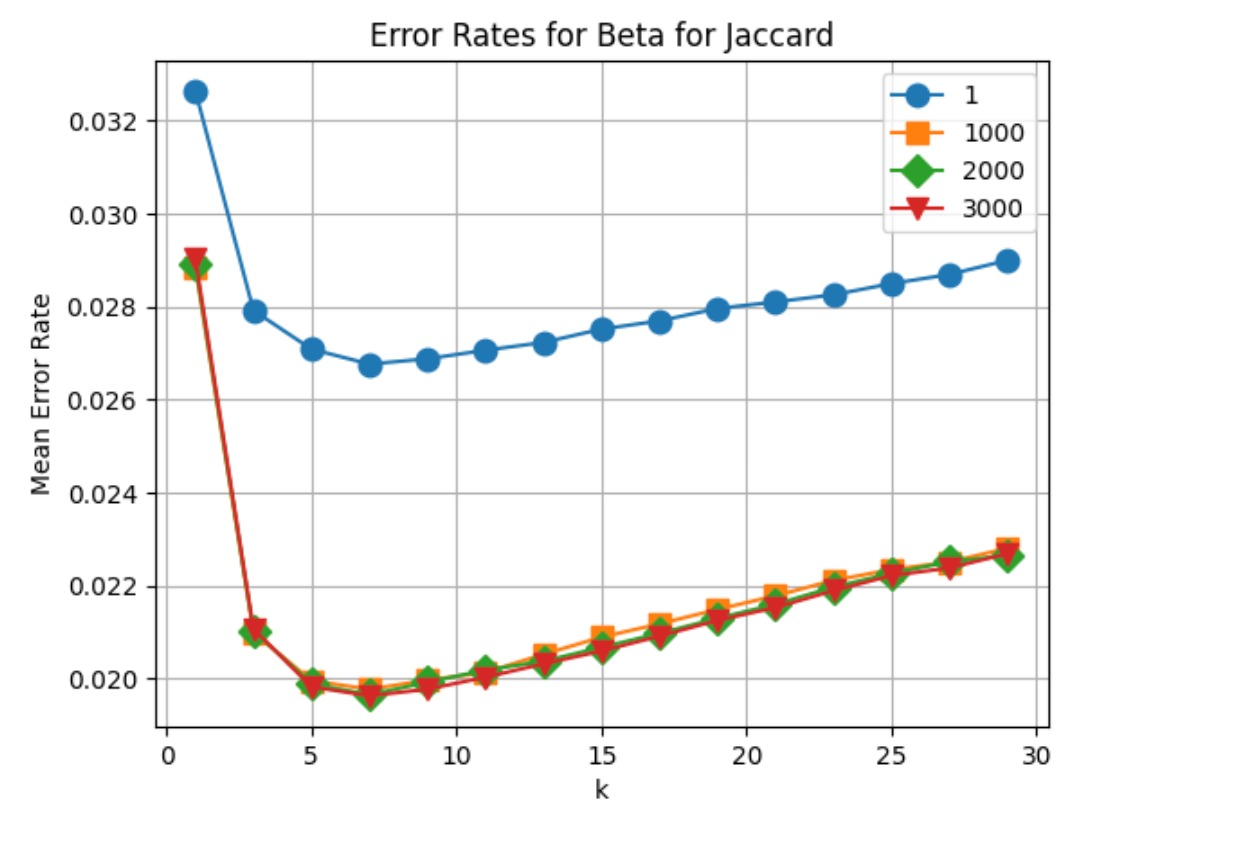

The following code creates submission in a `submission.csv` file.

In [ ]:
def create_submission(df, metrics=["jaccard"], k=20, normalization="log", beta=1000):
    training_set = df
    test_set = pd.read_csv("test_set.csv")

    train = df.iloc[:, 1 : df.shape[1]].astype("float32")
    test = test_set.iloc[:, 1 : test_set.shape[1]].astype("float32")

    if normalization == "min_max":
        train = min_max_normalization(train)
        test = min_max_normalization(test)
    elif normalization == "log1p":
        train = log1p_normalization(train)
        test = log1p_normalization(test)
    elif normalization == "log":
        train = log_normalization(train, beta)
        test = log_normalization(test, beta)

    results = calculate_distances_similarities_batched(
        train, test, metrics=["cosine"], batch_size=1000
    )
    test_set_neighbors = get_k_nearest_neighbors(results["cosine"], k=24)

    test_recommendations = get_recommendations(test_set_neighbors, test, train)

    all_recommendations = []

    for i in test_recommendations.columns:
        all_recommendations.append(test_recommendations[i])

    sub_df = pd.concat(all_recommendations, axis=0)

    submission_ids = pd.read_csv("submission_ids.csv")["Id"]
    sub_df.columns = ["Expected"]
    submission_ids.reset_index(drop=True, inplace=True)
    sub_df.reset_index(drop=True, inplace=True)
    submission_df = pd.concat([submission_ids, sub_df], axis=1)
    submission_df.columns = ["Id", "Expected"]
    submission_df.to_csv("submission.csv", index=False)


create_submission(df, ['jaccard'], 20, 'log', 1000)